<a href="https://colab.research.google.com/github/jerrymart/Machine-Learning-Projects/blob/main/Decision_Trees_Random_Forest_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BUSINESS CASE
Develope a model that is able to predict customer churn based of some given features 

## Approach

This is a classification problem, I used Decision Tree, Random Forest and XGBoost to exemplify the implementation.

This is a guild on using the 3 models above and how Hyper-Parameter optimization is done on Random Forest and XGBoost in business case depending on the size of the dataset

I carried out hyper-parameter optimization on the Random Forest and XGBoost algorithms using RandomizedSearchCV

The best of the model was XGBoost which would be deployed

### Load Libraries

In [4]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

# pip install graphviz

In [5]:
# Loading the data
raw_data = pd.read_csv('/content/cutomer_churn_raw_data.csv')

In [37]:
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [38]:
# print the shape
print(raw_data.shape)

(10000, 14)


### 4. Data Pre-Processing Phase

In [39]:
# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    num_of_values = len(unique_vals)
    if num_of_values < 12:
        print('The number of values for feature {} :{} -- {}'.format(column, num_of_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, num_of_values))

The number of values for feature RowNumber :10000
The number of values for feature CustomerId :10000
The number of values for feature Surname :2932
The number of values for feature CreditScore :460
The number of values for feature Geography :3 -- ['France' 'Germany' 'Spain']
The number of values for feature Gender :2 -- ['Female' 'Male']
The number of values for feature Age :70
The number of values for feature Tenure :11 -- [ 0  1  2  3  4  5  6  7  8  9 10]
The number of values for feature Balance :6382
The number of values for feature NumOfProducts :4 -- [1 2 3 4]
The number of values for feature HasCrCard :2 -- [0 1]
The number of values for feature IsActiveMember :2 -- [0 1]
The number of values for feature EstimatedSalary :9999
The number of values for feature Exited :2 -- [0 1]


In [40]:
# Checking for null values
raw_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [41]:
raw_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
# Limiting the data
raw_data2 = raw_data[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

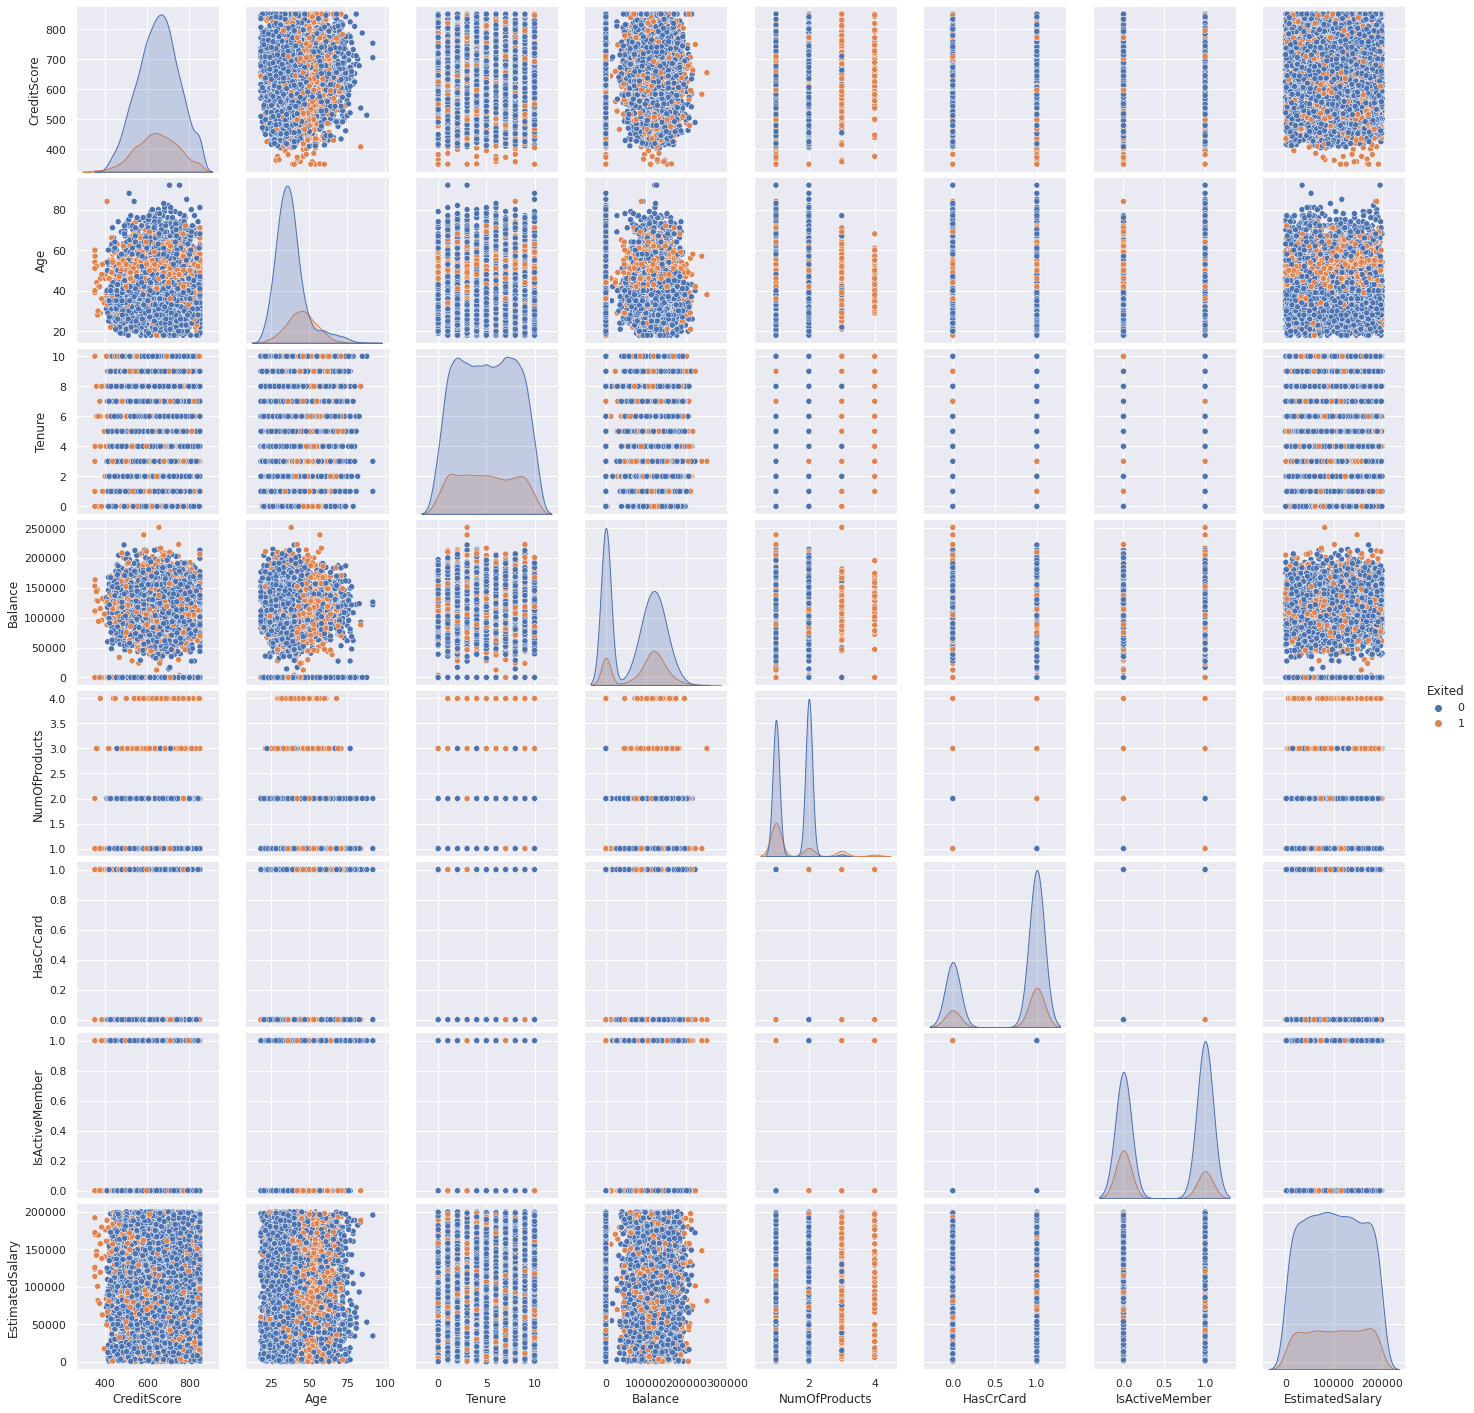

In [43]:
# Visualize the numeric data using seaborn Pairplots
#set hue==the target we are predicting
g = sns.pairplot(raw_data2, hue = 'Exited', diag_kws={'bw': 0.2})

In [7]:
# Investigate all the non numeric features by our y

features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard','IsActiveMember']


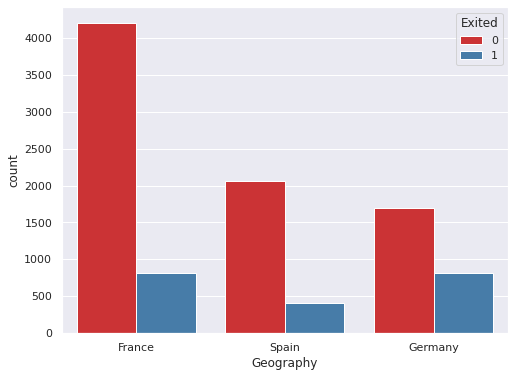

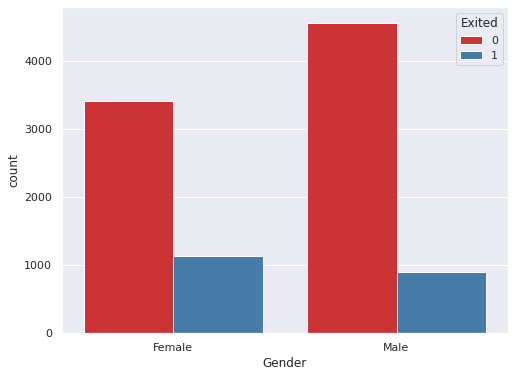

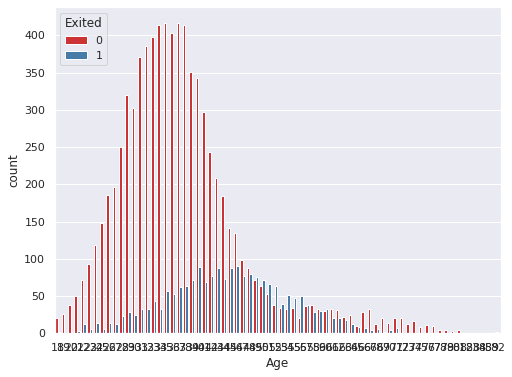

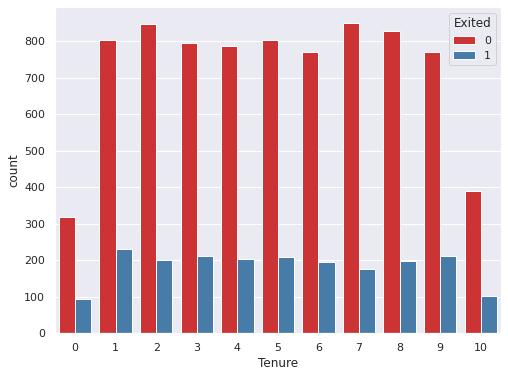

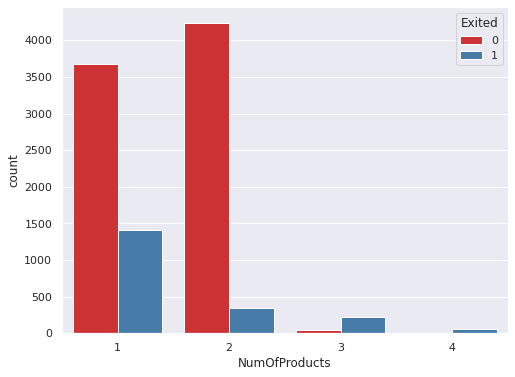

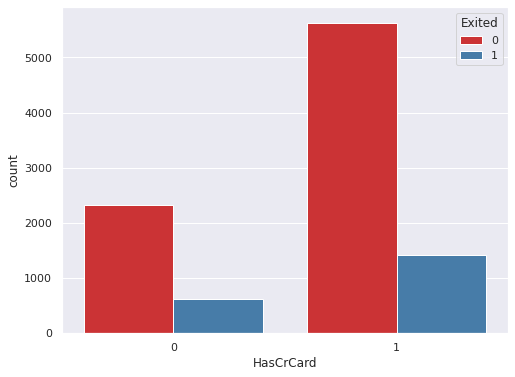

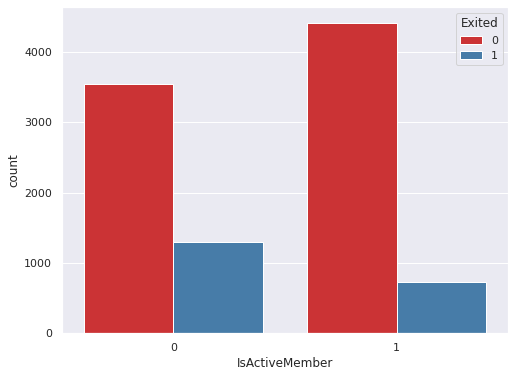

In [45]:
for feature in features:
    ax = sns.countplot(x=feature, data=raw_data2, hue = 'Exited', palette="Set1")
    plt.show() #plt.figure()

In [8]:
# Making categorical variables into numeric representation

new_raw_data = pd.get_dummies(raw_data2, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])

new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


In [47]:
new_raw_data.shape

(10000, 16)

In [9]:
# Scaling our columns

scale_vars = ['CreditScore','EstimatedSalary','Balance','Age']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars]) #new_raw_data[scale_vars] -> making the np.aaary new_raw_data a dataframe
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,1,0,0,1,0,0,1,0,1
1,0.516,0.310811,1,0.334031,1,0.562709,0,0,0,1,1,0,1,0,0,1
2,0.304,0.324324,8,0.636357,3,0.569654,1,1,0,0,1,0,0,1,1,0
3,0.698,0.283784,1,0.000000,2,0.469120,0,1,0,0,1,0,1,0,1,0
4,1.000,0.337838,2,0.500246,1,0.395400,0,0,0,1,1,0,0,1,0,1


In [49]:
type(new_raw_data[scale_vars])

pandas.core.frame.DataFrame

### 5. Splitting the Raw Data - Hold-out validation

In [19]:
X = new_raw_data.drop('Exited', axis=1).values      # Input features (attributes)
y = new_raw_data['Exited'].values                   # Target vector

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

X shape: (10000, 15)
y shape: (10000,)


### 6. Running Decision Tree

In [20]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

### Plot Decision Tree of the dt_model above for visualization

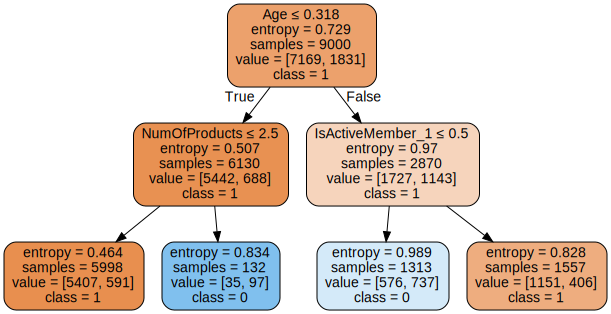

In [52]:
import graphviz 

dot_data = tree.export_graphviz(dt_model, out_file=None, 
    feature_names=new_raw_data.drop('Exited', axis=1).columns,    
    class_names=new_raw_data['Exited'].unique().astype(str),  
    filled=True, rounded=True,  
    special_characters=True)
decisionTree = graphviz.Source(dot_data)

decisionTree

## Check The Important Feature in The Model

In [53]:
# Calculating FI
for i, column in enumerate(new_raw_data.drop('Exited', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt_model.feature_importances_[i]))
    
    #make a dataframe of the fi
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt_model.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi

Importance of feature CreditScore:, 0.000
Importance of feature Age:, 0.622
Importance of feature Tenure:, 0.000
Importance of feature Balance:, 0.000
Importance of feature NumOfProducts:, 0.196
Importance of feature EstimatedSalary:, 0.000
Importance of feature Geography_France:, 0.000
Importance of feature Geography_Germany:, 0.000
Importance of feature Geography_Spain:, 0.000
Importance of feature Gender_Female:, 0.000
Importance of feature Gender_Male:, 0.000
Importance of feature HasCrCard_0:, 0.000
Importance of feature HasCrCard_1:, 0.000
Importance of feature IsActiveMember_0:, 0.000
Importance of feature IsActiveMember_1:, 0.182


In [54]:
# Ordering the data
final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index() 

final_fi

,index,Variable,Feature Importance Score
0,1,Age,0.622346
1,4,NumOfProducts,0.195552
2,14,IsActiveMember_1,0.182102
3,0,CreditScore,0.000000
4,2,Tenure,0.000000
5,3,Balance,0.000000
6,5,EstimatedSalary,0.000000
7,6,Geography_France,0.000000
8,7,Geography_Germany,0.000000
9,8,Geography_Spain,0.000000


### Check Accuracy of The Model

In [55]:
# Accuracy on Train
print("Training Accuracy is: ", dt_model.score(X_train, y_train))

# Accuracy on Test
print("Testing Accuracy is: ", dt_model.score(X_test, y_test))

Training Accuracy is:  0.8213333333333334
Testing Accuracy is:  0.822


In [21]:
y_pred = dt_model.predict(X_train)
y_pred

array([0, 1, 0, ..., 0, 0, 1])

### Confusion Matrix

In [22]:
confusion_matrix(y_train, y_pred)

array([[6558,  611],
       [ 997,  834]])

In [23]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

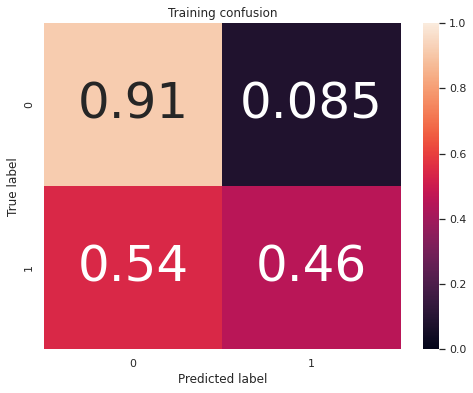

In [24]:
# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]   # normalize the cm


plt.figure()
plot_confusion_matrix(cm = cm_norm, classes=dt_model.classes_, title='Training confusion')

### How Good Is The Model

Calculate the TPR,FPR,Precision, FNR,CE

This tell us how good or bad the model is doing

In [60]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)


The True Positive rate / Recall per class is:  [0.914772 0.455489]
The Precision per class is:  [0.868034 0.577163]
The False Alarm rate per class is:  [0.544511 0.085228]
The Miss Rate rate per class is:  [0.085228 0.544511]
The Classification error of each class is [0.178667 0.178667]
The Accuracy of each class is [0.821333 0.821333]

The average Recall is:  0.685130369325603
The average Precision is:  0.7225985220264771
The average False Alarm is:  0.31486963067439694
The average Miss Rate rate is:  0.31486963067439694
The average Classification error is 0.17866666666666667
The average Accuracy is 0.8213333333333334


## Random Forest

Training Accuracy is:  1.0
Testing Accuracy is:  0.866


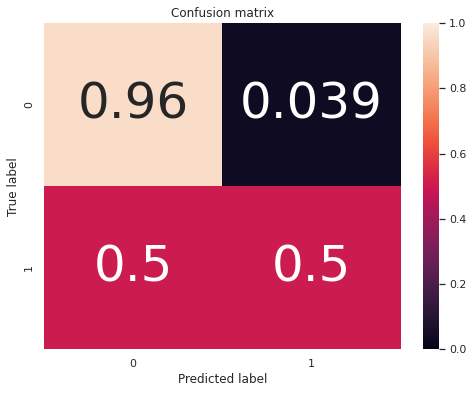

In [61]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.860
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.797
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.802
Classification accuracy on test set with max features = 1 and max_depth = 18: 0.861
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.868
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.800
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.812
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.831
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.850
Classification accuracy on test set with max features = sqrt and 

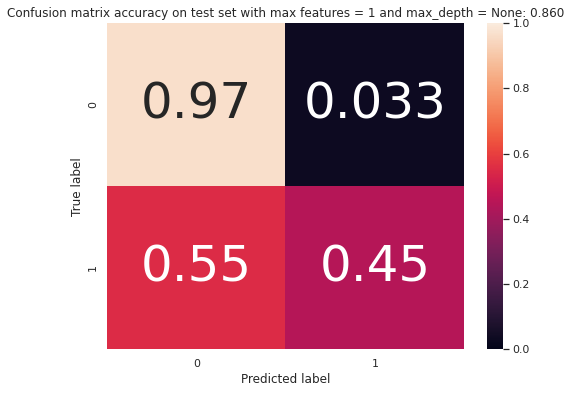

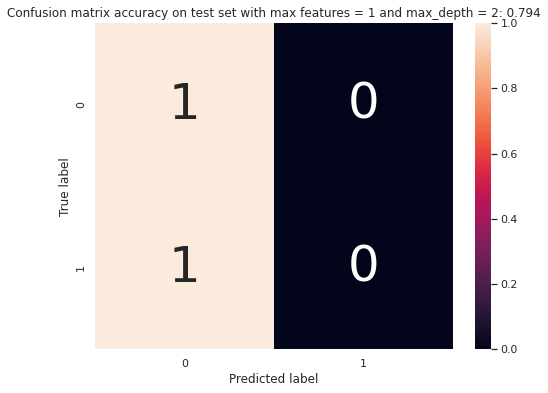

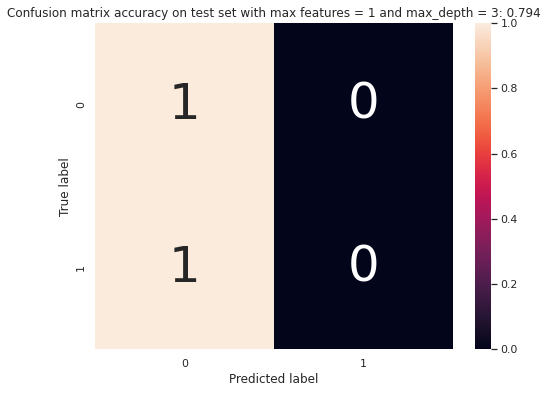

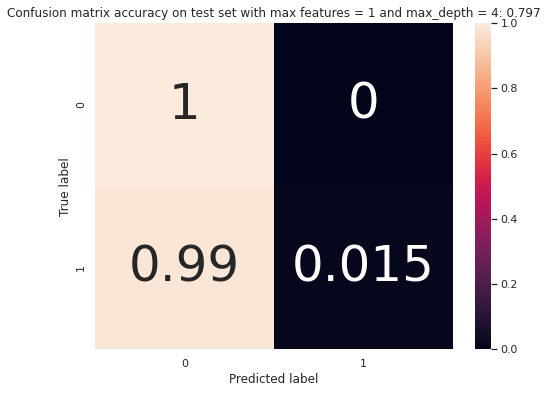

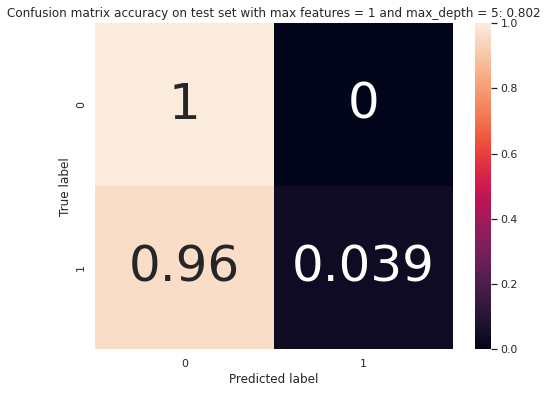

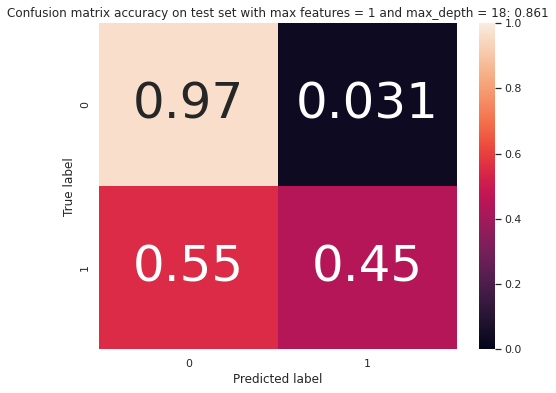

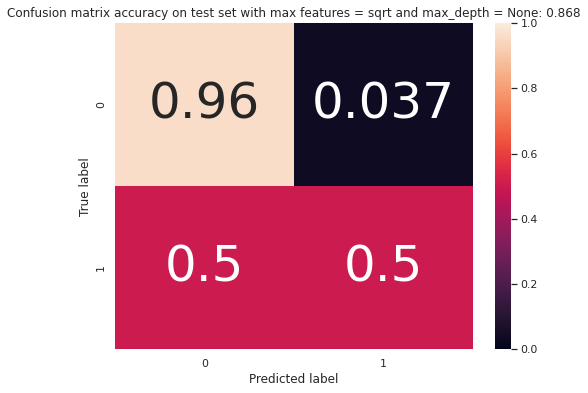

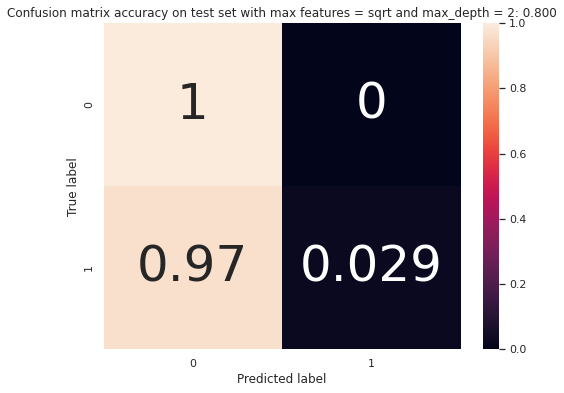

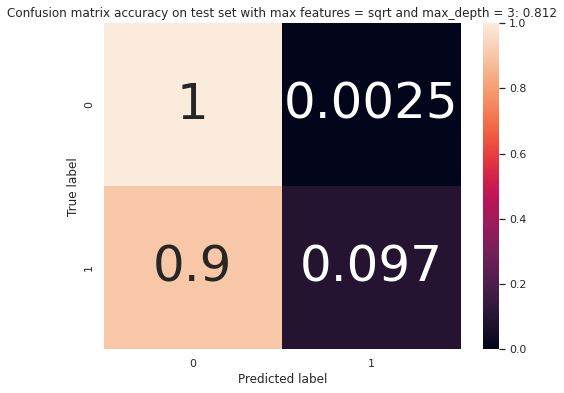

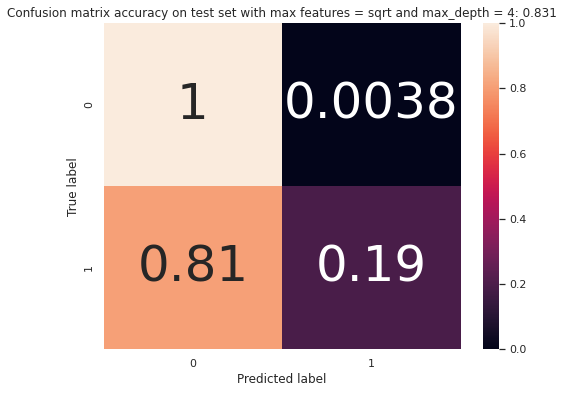

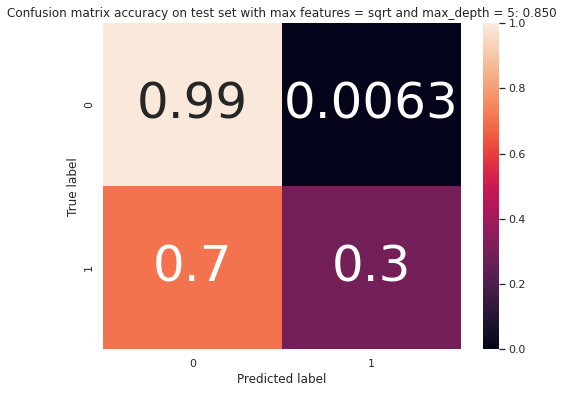

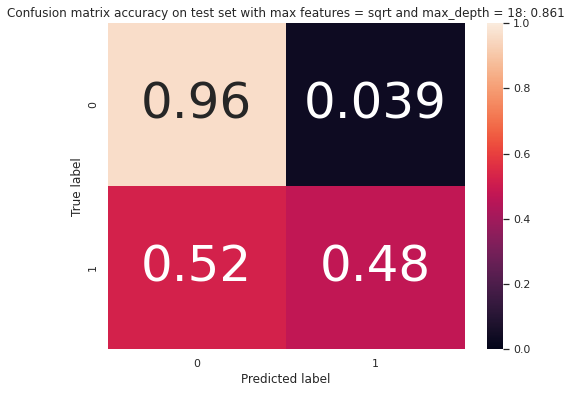

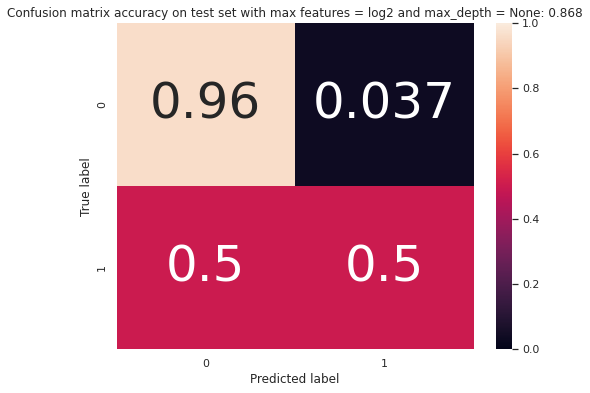

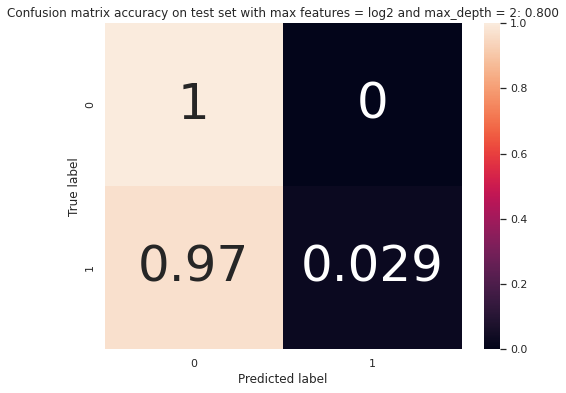

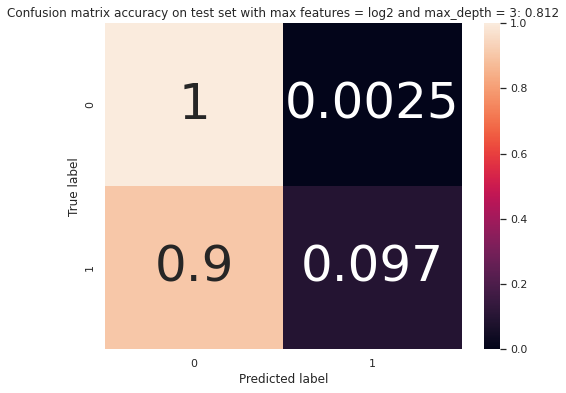

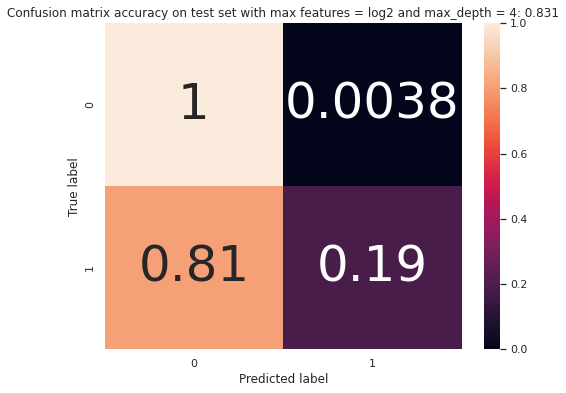

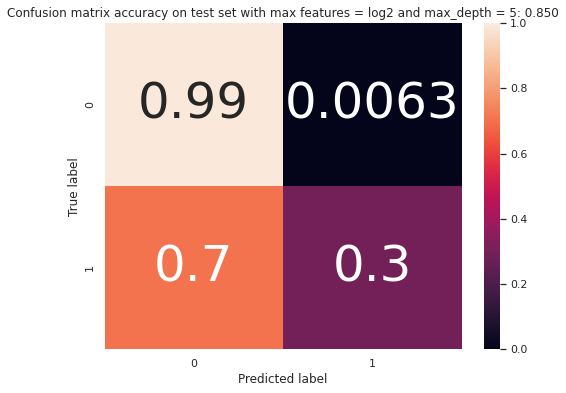

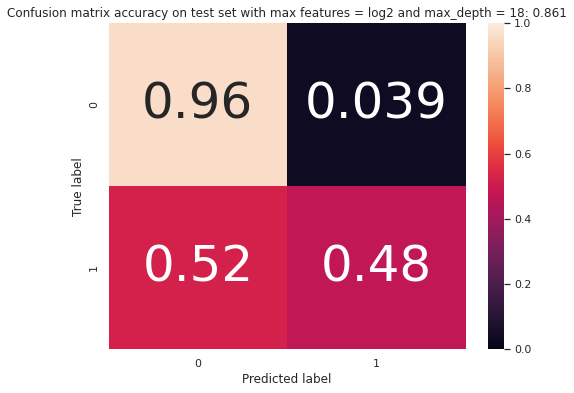

In [62]:
# Tunning Random Forest

from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
#max_depths = range(1,50)
max_depths = [None, 2, 3, 4, 5,18]


for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

The best combination is [max_features='log2', max_depth=None, n_jobs=2, n_estimators=100, criterion="entropy"]

These will be used to build our best_tuned_rf

In [63]:
best_tuned_rf = RandomForestClassifier(max_features='log2', max_depth=None, n_jobs=2, n_estimators=100, criterion="entropy")
best_tuned_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2', n_jobs=2)

In [64]:
print (f'Train Accuracy - : {best_tuned_rf.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {best_tuned_rf.score(X_test,y_test):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.865


The best_tuned_rf is not doing any better than the untuned rf model

We will try using RandomizedSerchCV to tune further

## RF Hyper-parameter Tuning With RandomizedSearchCV

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = range(0,50)
# Minimum number of samples required to split a node
min_samples_split = range(0, 20)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(0,20)
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [66]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': range(0, 50), 'min_samples_split': range(0, 20), 'min_samples_leaf': range(0, 20), 'bootstrap': [True, False]}


In [67]:
from sklearn.model_selection import RandomizedSearchCV
rf_Model = RandomForestClassifier()
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 2,random_state=10,n_iter=15)

In [68]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=15,
                   n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(0, 50),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(0, 20),
                                        'min_samples_split': range(0, 20),
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=10, verbose=2)

In [69]:
rf_RandomGrid.best_params_

{'bootstrap': True,
 'max_depth': 17,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'n_estimators': 70}

In [70]:
rf_RandomGrid.best_estimator_

RandomForestClassifier(max_depth=17, max_features='sqrt', min_samples_split=9,
                       n_estimators=70)

In [71]:
#Build the model with best_params
clf = RandomForestClassifier(n_estimators=80,max_depth=45,max_features="auto", min_samples_leaf=4,
                       min_samples_split=15,bootstrap=False
                    )

clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, max_depth=45, min_samples_leaf=4,
                       min_samples_split=15, n_estimators=80)

In [ ]:
y_pred = clf.predict(X_train)

In [72]:
print (f'Train Accuracy - : {clf.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {clf.score(X_test,y_test):.3f}')

Train Accuracy - : 0.922
Test Accuracy - : 0.866


In [85]:
confusion_matrix(y_train, y_pred)

array([[7101,   68],
       [ 634, 1197]])

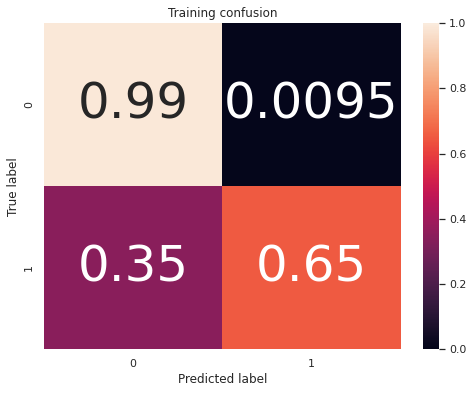

In [74]:
# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]   # normalize the cm


plt.figure()
plot_confusion_matrix(cm = cm_norm, classes=clf.classes_, title='Training confusion')

### Using randomizedsearch to build a rf model gave the best result as seen in the confusion matrix (0.65)  compared to the rf model and manual best_tuned_rf 

This is how we can do hyper-parameter tuning on Random Forest using above 2 methods

Next, we will use XGBoost on the data and see if it permforms better

## XGBoost

## XGBoost Hyper-parameter Optimization RandomizedSearchCV `

In [75]:
#!pip install xgboost

In [11]:
#import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgbclf=XGBClassifier(tree_method='gpu_hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.26,0.27,0.28,0.30,0.31,0.33,0.40],
    "max_depth":[2,3,4,5,6,8,10,12,15,18,21],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7,0.8]}
randomGrid =RandomizedSearchCV(xgbclf,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html



In [12]:
# fitting RandomizedSearchCV
randomGrid.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.838 total time=   3.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.841 total time=   2.3s
[CV 3/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.843 total time=   2.4s
[CV 4/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.841 total time=   2.3s
[CV 5/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.828 total time=   2.3s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3;, score=0.851 total time=   1.5s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3;, score=0.853 total time=   1.5s
[CV 3/5] END colsample_bytree=

RandomizedSearchCV(cv=5, estimator=XGBClassifier(tree_method='gpu_hist'),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                                             0.8],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.26, 0.27,
                                                          0.28, 0.3, 0.31, 0.33,
                                                          0.4],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15, 18, 21],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [13]:
randomGrid.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 1}

In [14]:
randomGrid.best_estimator_

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=15,
              tree_method='gpu_hist')

In [15]:
xgb_model = XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=15,
              tree_method='gpu_hist')

In [16]:
# fitting it
xgb_model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=15,
              tree_method='gpu_hist')

[[7935   28]
 [ 432 1605]]


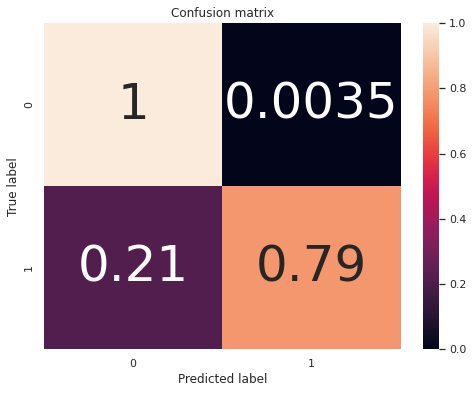

In [34]:
xgboost_pred = xgb_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, xgboost_pred)
print(cm)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=xgb_model.classes_)

In [30]:
print (f'Train Accuracy - : {xgb_model.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {xgb_model.score(X_test,y_test):.3f}')

Train Accuracy - : 0.966
Test Accuracy - : 0.850


In [33]:
#WOW !!! XGBoost has boosted the TN to 0.79 almost 80% classification accuracy

#XGBoost is our final model which we shall deploy

In [32]:
xgboost_pred

array([1, 0, 1, ..., 0, 0, 0])